# Single adaptive Kramers chain

Start from recalling the SDE for one bead in a chains:

\begin{equation}
\mathrm{d}X_i =\left(X_i\nabla U + \frac{g_i}{\zeta_i\ell_i} Q_i - \frac{g_{i-1}}{\zeta_i\ell_{i-1}}Q_{i-1}\right)\mathrm{d}t + \mathrm{d}W_i
\end{equation}

$\mathrm{d}W_i$ are drawn from a normal distribution with zero mean and variance $2 kT \mathrm{d}t/\zeta_i$ per each coordinate. The SDE for each rod will be:

\begin{equation}
\mathrm{d}Q_i =\left(Q_i\nabla U + \frac{g_{i-1}}{\zeta_i\ell_{i-1}}Q_{i-1} - \left( \frac{1}{\zeta_{i+1}} + \frac{1}{\zeta_i}\right)\frac{g_i}{\ell_i} Q_i + \frac{g_{i+1}}{\zeta_{i+1}\ell_{i+1}}Q_{i+1}\right)\mathrm{d}t + \mathrm{d}W_{i+1}-\mathrm{d}W_{i}
\end{equation}

This system holds also in dimensionless form where $\ell_i=1$ and $\zeta_i=1$ for unit beads and rods. Merging rods gives integers $\ell_i$, but we have options for the dimensionless friction. Here we choose to balance the weight of beads on both sides:

\begin{equation}
\zeta_i = \frac{\ell_{i-1}+\ell_{i}}{2}
\end{equation}

with the convention $\ell_{-1}=\ell_{i+1}=1$ at chain ends. Since the contour length is constant and is given by $\sum \ell_i=N$, we can check that in this way $\sum\zeta_i=N+1$, so the chain has always the same total friction as a regular Kramers chain of $N+1$ beads.

The left-hand side of the tridiagonal system for the tension is now:

\begin{equation}
- g_{i-1}\frac{Q_{i-1}\cdot Q_i}{\zeta_i\ell_{i-1}} + \left( \frac{\ell_i}{\zeta_{i+1}} + \frac{\ell_i}{\zeta_i}\right)g_i - g_{i+1}\frac{Q_{i+1}\cdot Q_i}{\zeta_{i+1}\ell_{i+1}} =\left( Q_i\nabla U + \frac{\mathrm{d}W_{i+1} -\mathrm{d}W_{i}}{\mathrm{d}t}\right) \cdot Q_i + \frac{\mathrm{d}Q_i^2}{2\mathrm{d}t}
\end{equation}



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dilutebrowniandynamics.simulate import simulate
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain

np.random.seed(2023)

## Parameters definition

In [2]:
n_links = 256       # Number of segments in the Kramers chain 64, 256, 1024

dt = .01           # Time step value (dimensionless)
n_steps = 2000     # Number of time steps to simulate
write_interval = 10 # How often data is recorded (1 means every time step)
n_proc = 16        # Number of processor cores to use (for batch processing)

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
# Starting vectors
molecule = AdaptiveKramersChain.from_normal_distribution(n_links)

We can plot this molecule using matplotlib 3d capabilities: firt we need to convert links to coordinates.

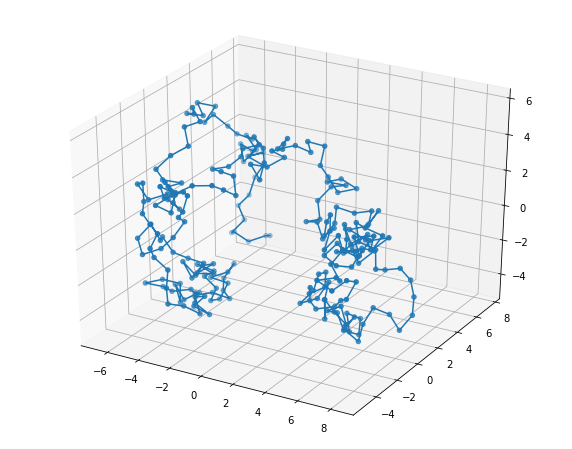

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = molecule.coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
ax.plot(x, y, z)
ax.scatter(x, y, z, s=20)

Or we can export the molecule to vtk format which can be read by Paraview.

In [5]:
molecule.save_vtk('outputs/vtk/example.vtk')

## Initial relaxation
Thermalisation step.

In [6]:
gradU = np.zeros((3, 3))
observables, molecule_init = simulate(molecule, gradU, dt, n_steps,
                                     write_interval=write_interval, full_trajectory=False, progress=True)

100%|██████████| 2000/2000 [00:05<00:00, 369.21it/s]


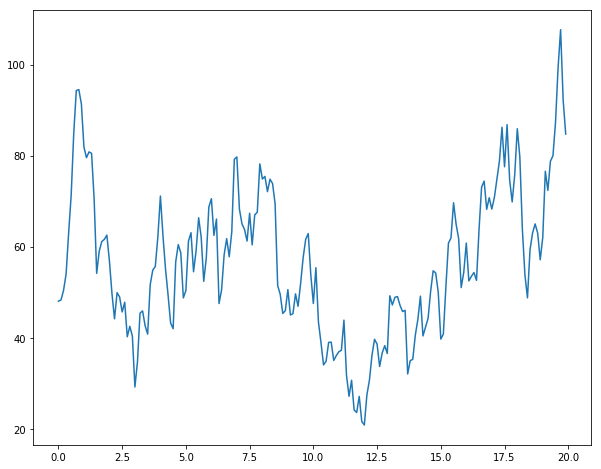

In [7]:
t = np.arange(n_steps//write_interval)*dt*write_interval
plt.plot(t, observables['A'][:,0,0])

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [8]:
#%load_ext line_profiler
#%lprun -f simulate simulate(molecule, gradU, 1000, 0.01, full_trajectory=False, progress=True)

In [9]:
#%lprun -f AdaptiveKramersChain.solve molecule.solve(np.zeros((3,3)), 0.001)

## Relaxation via fluctuations

## Uniaxial elongation

In [10]:
gradU = np.diag([10, -5, -5])
dt = .01           # Time step value (dimensionless)
n_steps = 500
write_interval = 1
print(f"Length of time series: {n_steps//write_interval}")
observables, _ = simulate(molecule_init, gradU, dt, n_steps,
                                     write_interval=write_interval, full_trajectory=True, progress=True)

Length of time series: 500


100%|██████████| 500/500 [00:06<00:00, 82.86it/s] 


135.5


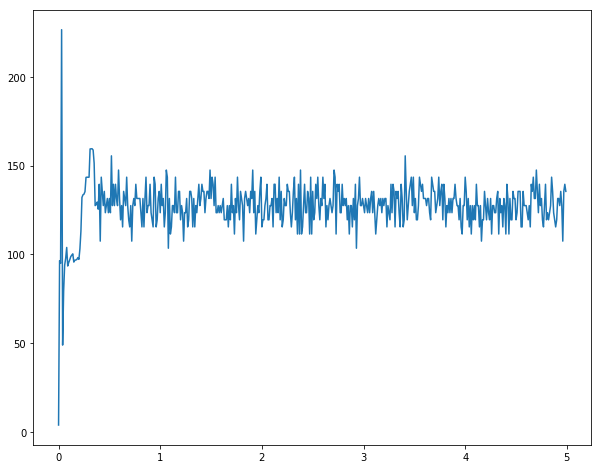

In [11]:
t = np.arange(n_steps//write_interval)*dt*write_interval
plt.plot(t, observables['i_max'])
print(observables['i_max'][-1])

82697.86750277564 82567.00897431502


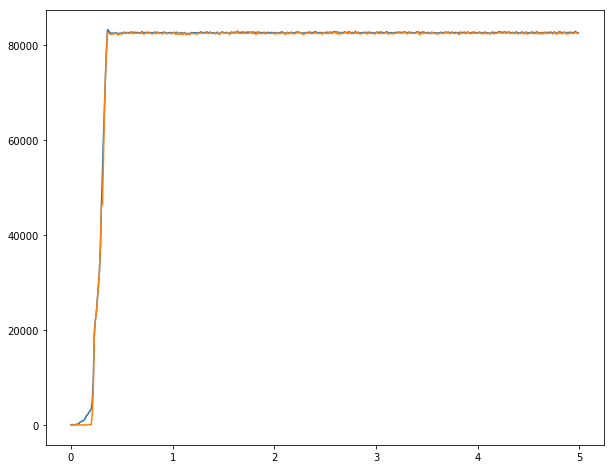

In [12]:
plt.plot(t, observables['g_max'])
plt.plot(t, observables['g_centre'])
print(observables['g_max'][-1], observables['g_centre'][-1])

In [13]:
#molecule_init._beads[np.argmax(molecule_init._beads)]
np.cumsum(molecule_init._beads)-1

array([  0.5,   2.5,   5.5,  11.5,  23.5,  47.5,  95.5, 159.5, 207.5,
       231.5, 243.5, 249.5, 252.5, 254.5, 256. ])

In [14]:
molecule_init._beads

array([ 1.5,  2. ,  3. ,  6. , 12. , 24. , 48. , 64. , 48. , 24. , 12. ,
        6. ,  3. ,  2. ,  1.5])

In [15]:
np.cumsum(np.sqrt(molecule_init.L2[:-1])) + 0.5*np.sqrt(molecule_init.L2[1:]) -1.5

array([  1.5,   4.5,  10.5,  22.5,  46.5,  94.5, 158.5, 206.5, 230.5,
       242.5, 248.5, 251.5, 253.5])